# Spectral Analysis 

## 1. Import Datasets

In [2]:
import numpy as np
import pandas as pd
import h5py
import dask.array as da
import dask.dataframe as dd
import dask
import matplotlib.pyplot as plt

file = '../../data/pair3.mat'

f = h5py.File(file, 'r')

trace = f['s_traces']
trace_T = trace[:].T
s_traces = da.from_array(trace_T, chunks=(10000, 10000))

s_traces_real = s_traces['real']  
s_traces_imag = s_traces['imag']
df_real = dd.from_dask_array(s_traces_real, columns=[i for i in range(s_traces_real.shape[1])])
df_i = dd.from_dask_array(s_traces_imag, columns= [i for i in range(s_traces_imag.shape[1])])

print(df_real.head())

       0         1         2         3         4         5         6     \
0  0.000266  0.000339  0.000397  0.000432  0.000439  0.000414  0.000355   
1 -0.000195 -0.000104 -0.000008  0.000088  0.000182  0.000268  0.000341   
2  0.000330  0.000295  0.000229  0.000140  0.000036 -0.000075 -0.000181   
3  0.000382  0.000312  0.000213  0.000092 -0.000038 -0.000163 -0.000269   
4  0.000020  0.000073  0.000113  0.000137  0.000142  0.000130  0.000104   

       7         8         9     ...  5990  5991  5992  5993  5994  5995  \
0  0.000264  0.000147  0.000013  ...   0.0   0.0   0.0   0.0   0.0   0.0   
1  0.000397  0.000430  0.000436  ...   0.0   0.0   0.0   0.0   0.0   0.0   
2 -0.000274 -0.000345 -0.000389  ...   0.0   0.0   0.0   0.0   0.0   0.0   
3 -0.000344 -0.000378 -0.000367  ...   0.0   0.0   0.0   0.0   0.0   0.0   
4  0.000065  0.000019 -0.000030  ...   0.0   0.0   0.0   0.0   0.0   0.0   

   5996  5997  5998  5999  
0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0  
2   0.0 

## 2. Datetime processing

In [3]:
from datetime import timedelta, datetime

with h5py.File(file, "r") as mat_file:
    s_dates = mat_file["s_dates"][:]  
s_dates = s_dates.flatten()

def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    python_date = datetime.fromordinal(int(datenum)) \
           + timedelta(days=days) \
           - timedelta(days=366)
    
    if python_date.second > 30:
        python_date = python_date + timedelta(minutes=1)  
        python_date = python_date.replace(second=0)  

    return python_date.strftime("%Y-%m-%d-%H-%M")

s_dates_to_python = np.array([datenum_to_datetime(d) for d in s_dates])
s_dates_df = pd.DataFrame(s_dates_to_python, columns= ['date'])

s_dates_df

,date
0,2012-01-04-09-28
1,2012-01-04-09-49
2,2012-01-04-10-27
3,2012-01-04-11-05
4,2012-01-04-11-13
...,...
76675,2021-06-08-10-06
76676,2021-06-08-10-08
76677,2021-06-08-10-10
76678,2021-06-08-10-11


## 3. Spectral analysis method using Machine learning

### Adding label to the data

In [4]:
def get_index(time, date_df):
    return date_df[date_df['date'].isin(time)].index.to_numpy()

defect_pos = int(get_index(['2021-06-08-09-15'], s_dates_df))
defect_pos

C:\Users\qq24422\AppData\Local\Temp\ipykernel_3368\2192542057.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  defect_pos = int(get_index(['2021-06-08-09-15'], s_dates_df))


76650

In [5]:
def add_label(df, defect_id):
    
    m = len(df)
    y = np.zeros(m)
    y[defect_id:] = 1
    yint = y.astype(int)

    return yint

label = add_label(df_real, defect_pos)

In [6]:
label

array([0, 0, 0, ..., 1, 1, 1])

### Transforming signal data from Time Domain to Frequency Domain

In [7]:
from scipy.fft import rfft, rfftfreq

def fourier(signal, sampling_rate=1.0):
    fft_features = np.abs(rfft(signal, axis=1))
    freqs = rfftfreq(signal.shape[1], d= 1./sampling_rate)
    return fft_features, freqs

In [8]:
X_time = df_real.values.compute()  
X_freq, freqs = fourier(X_time, sampling_rate=1.0)

This code defines a Fourier Transform function, which converts a signal from the time domain to the frequency domain using the Real Fast Fourier Transform (rFFT). In structural health monitoring or defect detection, defects often manifest as changes in vibration patterns or introduce high-frequency noise that is not easily noticeable in the time domain. The frequency domain exposes these changes clearly by isolating where energy is concentrated across different frequency bands.

Another important aspect is that the frequency domain provides a more stable representation of repetitive or periodic phenomena. While time-domain signals can vary significantly due to shifts, noise, or operational conditions, their frequency characteristics tend to remain consistent for similar structural behaviors. This consistency makes frequency-based features highly reliable for machine learning models, improving classification performance between pristine and defective states.

Moreover, working in the frequency domain allows us to focus only on the relevant features. For instance, low or high-frequency ranges that carry no useful information can be easily filtered out, reducing dimensionality and noise. This targeted approach not only enhances the interpretability of the data but also boosts the discriminative power of models, as seen in the feature importance analysis where certain frequency bins stand out. These bins represent frequencies where defects consistently differ from normal behavior — something that would be far harder to pinpoint using raw time signals.

### Sampling Data

In this dataset, there is a significant imbalance between the number of pristine and defect samples, with thousands of pristine signals but only around 30 defect examples available. Using the entire dataset as-is would create a severe class imbalance, which could negatively impact model performance. A heavily imbalanced dataset tends to bias the model toward predicting the majority class, in this case, pristine signals, leading to poor detection of defects. To address this, an equal number of samples from both classes were selected to ensure balanced training.

Additionally, instead of limiting the selection to a specific period like only using data from 2012, which could introduce temporal bias and fail to capture the variability present across different timeframes, a uniform sampling approach was applied. This ensures that the selected pristine signals are spread throughout the dataset, making the training data more representative of the overall signal behavior across time. This strategy helps the model generalize better and reduces the risk of overfitting to patterns unique to a specific period.

In [9]:
defect_idx = np.where(label == 1)[0]
normal_idx = np.where(label == 0)[0]

np.random.seed(1000)
np.random.shuffle(defect_idx)
np.random.shuffle(normal_idx)

n_defect = 30
n_normal = 45
selected_normal_idx = normal_idx[:n_normal]
selected_idx = np.concatenate([selected_normal_idx, defect_idx])
np.random.shuffle(selected_idx)

In [10]:
selected_idx

array([18467, 76668, 76673, 76667, 76654, 59309, 76664,  7310,  9019,
       16195, 76651, 27255, 53122, 26478,   570, 17674, 10545, 76676,
       75403, 44610, 25179, 39312, 58089, 56672,  2516, 76655, 76670,
       64469, 76650, 76666, 10261, 76662, 72247, 16320, 70520, 76665,
        4832, 76663, 76658, 40695, 76675, 39999, 51649, 49053, 76669,
       27765, 76656, 55275, 72634, 48121, 14224, 41316, 59289, 76671,
       76652, 76660, 31330, 76657, 67982, 76679, 28039, 76672, 76659,
       72385, 30164, 76678,  7860, 73347, 32947, 74881, 76661, 76677,
       76674,  2038, 76653], dtype=int64)

In [11]:
X_subset = X_freq[selected_idx]
y_subset = label[selected_idx]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_subset, y_subset, test_size=0.5, random_state=42, stratify=y_subset)

In [12]:
y_train

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0])

In [13]:
y_test

array([0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1])

### Plotting and Analyzing Frequency Domain data

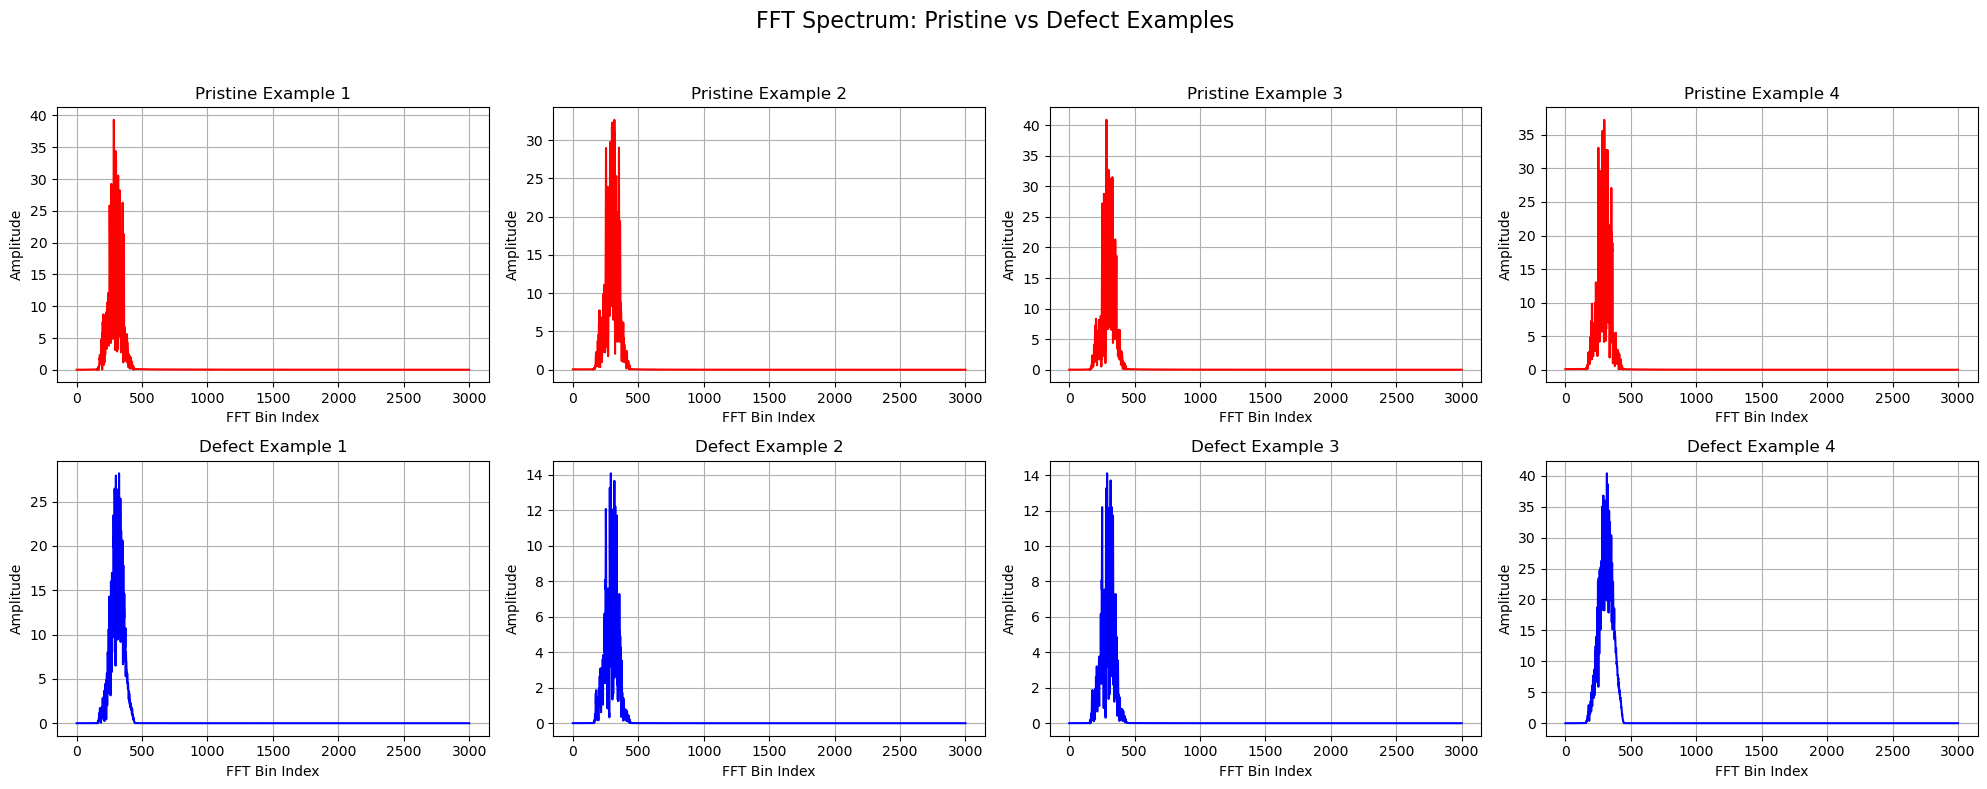

In [14]:
pristine_indices = np.random.choice(np.where(y_subset == 0)[0], 4, replace=False)
defect_indices = np.random.choice(np.where(y_subset == 1)[0], 4, replace=False)

fig, axes = plt.subplots(2, 4, figsize=(20, 8))  # 2 rows, 4 columns

# Plot 4 pristine examples
for i, idx in enumerate(pristine_indices):
    axes[0, i].plot(X_subset[idx], color='red')
    axes[0, i].set_title(f'Pristine Example {i+1}')
    axes[0, i].set_xlabel('FFT Bin Index')
    axes[0, i].set_ylabel('Amplitude')
    axes[0, i].grid(True)

# Plot 4 defect examples
for i, idx in enumerate(defect_indices):
    axes[1, i].plot(X_subset[idx], color='blue')
    axes[1, i].set_title(f'Defect Example {i+1}')
    axes[1, i].set_xlabel('FFT Bin Index')
    axes[1, i].set_ylabel('Amplitude')
    axes[1, i].grid(True)

fig.suptitle('FFT Spectrum: Pristine vs Defect Examples', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [15]:
pristine_amplitudes = X_subset[y_subset == 0]
defect_amplitudes = X_subset[y_subset == 1]

# Compute statistics with quartiles
def compute_stats_with_quartiles(data):
    mean_amp = np.mean(data)
    amp_range = np.max(data) - np.min(data)
    variance = np.var(data)
    q1 = np.percentile(data, 25)
    q2 = np.percentile(data, 50)  
    q3 = np.percentile(data, 75)
    return [mean_amp, amp_range, variance, q1, q2, q3]

# Calculate for both classes
pristine_stats = compute_stats_with_quartiles(pristine_amplitudes.flatten())
defect_stats = compute_stats_with_quartiles(defect_amplitudes.flatten())

# Create DataFrame
df_summary = pd.DataFrame({
    'Class': ['Pristine', 'Defect'],
    'Mean Amplitude': [pristine_stats[0], defect_stats[0]],
    'Amplitude Range': [pristine_stats[1], defect_stats[1]],
    'Variance': [pristine_stats[2], defect_stats[2]],
    'Q1 (25%)': [pristine_stats[3], defect_stats[3]],
    'Median (50%)': [pristine_stats[4], defect_stats[4]],
    'Q3 (75%)': [pristine_stats[5], defect_stats[5]]
})

df_summary

,Class,Mean Amplitude,Amplitude Range,Variance,Q1 (25%),Median (50%),Q3 (75%)
0,Pristine,0.714378,47.121503,10.606427,0.004682,0.010372,0.022138
1,Defect,0.602216,40.401273,8.480826,0.001099,0.001740,0.003282


This analysis focuses on comparing pristine and defect signals in the frequency domain using FFT. The x-axis in each plot represents the FFT bin index, which corresponds to specific frequency components in the signal, while the y-axis shows the amplitude, indicating the strength or energy of those frequencies. Each subplot visualizes how signal energy is distributed across frequencies for both pristine and defect examples.

From the individual plots, we observe a clear trend where most amplitude values are concentrated near zero across the majority of the frequency spectrum. Significant amplitude peaks only occur within a narrow frequency range, typically below the 500th FFT bin. This suggests that both pristine and defect signals primarily contain low-frequency components, while higher frequencies carry minimal energy. The statistical table supports this observation, showing that although the total amplitude range is large (over 40 units), the 75th percentile (Q3) values are very low for both classes. This confirms that most amplitude values remain small, with only a few high peaks causing the large range and variance.

When comparing the two classes, it is evident that pristine signals generally exhibit higher amplitude values than defect signals. The mean amplitude for pristine signals is approximately 0.71, whereas for defect signals it is lower at 0.60. This difference indicates that pristine signals tend to retain more energy across frequencies, while defect signals lose energy, likely due to structural anomalies. This consistent gap between the two classes in terms of energy distribution highlights a key discriminative feature for defect detection in the frequency domain.

### Defining a classification threshold

Now that we have identified clear differences between pristine and defect signals in the frequency domain, particularly in terms of amplitude distribution and energy concentration, we can move forward and apply these findings to classification. The statistical patterns we observed, such as the lower average amplitude and reduced variance in defect signals, suggest that these frequency-domain characteristics can serve as reliable indicators for distinguishing between the two classes.

To make use of these patterns, we need a model that can handle complex relationships within the data. A Random Forest classifier is a strong candidate because it is robust to noise, can manage high-dimensional feature spaces, and is effective at capturing non-linear interactions. Additionally, it provides useful insights through feature importance, which complements our analysis. The next step is to train this model using the FFT-based features and assess its ability to accurately differentiate between pristine and defect signals based on the characteristics we have uncovered.

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

clf_forest = RandomForestClassifier(n_estimators=100, random_state=42)
clf_forest.fit(X_train, y_train)

y_pred_forest = clf_forest.predict(X_test)
print(confusion_matrix(y_test, y_pred_forest))
print(classification_report(y_test, y_pred_forest))

[[21  2]
 [ 0 15]]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        23
           1       0.88      1.00      0.94        15

    accuracy                           0.95        38
   macro avg       0.94      0.96      0.95        38
weighted avg       0.95      0.95      0.95        38



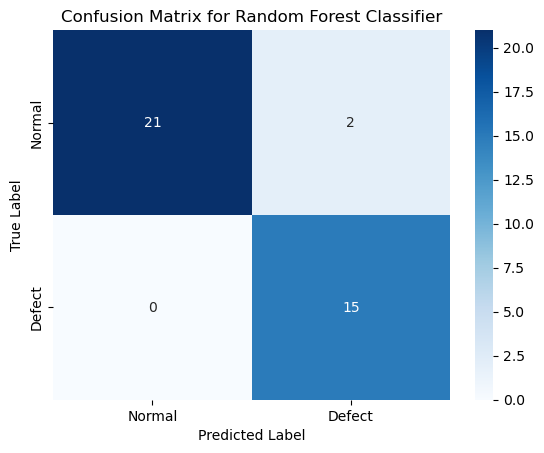

In [17]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_forest)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Defect"], yticklabels=["Normal", "Defect"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

The confusion matrix displayed here summarizes the performance of the Random Forest classifier on the test set. The model shows strong results, correctly classifying 21 out of 23 pristine signals and all 15 defect signals. There are only 2 false positives, where pristine signals were incorrectly classified as defects. Notably, there are no false negatives, meaning the model did not miss any defect cases.

This outcome highlights a desirable behavior for defect detection tasks, prioritizing the identification of defects even at the cost of a few false alarms. In practical applications, it's generally safer to flag a pristine signal for further inspection than to overlook a defect. The overall accuracy of 95% and perfect recall for defects demonstrate that the Random Forest model, leveraging frequency-domain features, is highly effective in distinguishing between pristine and defect conditions. The slight trade-off in precision for the pristine class is acceptable given the context, where missing a defect would be far more critical than conducting additional checks on a misclassified pristine signal.

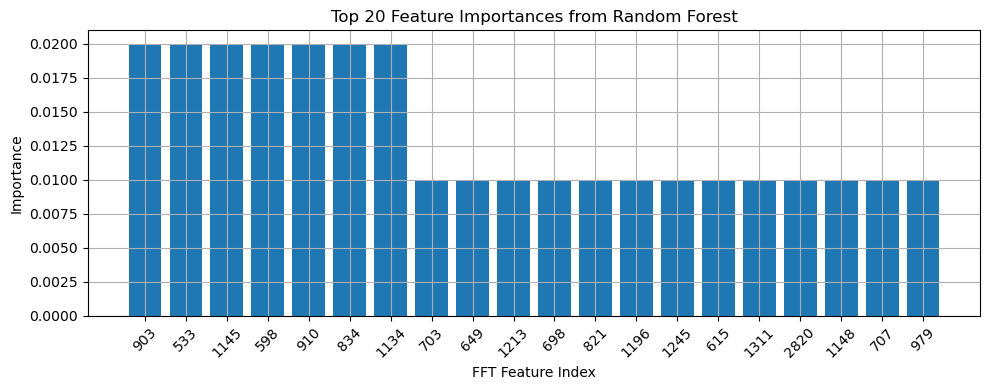

In [18]:
# Get feature importances and sort
importances = clf_forest.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot top 20 features
plt.figure(figsize=(10, 4))
plt.title("Top 20 Feature Importances from Random Forest")
plt.bar(range(20), importances[indices[:20]])
plt.xticks(range(20), indices[:20], rotation=45)
plt.xlabel("FFT Feature Index")
plt.ylabel("Importance")
plt.tight_layout()
plt.grid(True)
plt.show()

 After training the model on the frequency-domain data, I extracted the feature importance scores provided by the Random Forest. These scores indicate how much each FFT bin contributed to improving the model’s decision-making process.

The bar chart visualizes the top 20 most important FFT bins based on these scores. As seen in the plot, bins like 903, 533, 1145, and 598 stand out as the most influential features. These frequency points are where the model consistently found clear patterns that help separate defects from pristine conditions. Essentially, the higher the bar, the more that particular frequency contributed to accurate classification.

In [19]:
split_features = []
split_thresholds = []

for tree in clf_forest.estimators_:
    split_features.extend(tree.tree_.feature)
    split_thresholds.extend(tree.tree_.threshold)

# Convert to numpy arrays
split_features = np.array(split_features)
split_thresholds = np.array(split_thresholds)

# Remove -2 entries (which indicate leaf nodes)
valid_splits = split_features != -2
split_features = split_features[valid_splits]
split_thresholds = split_thresholds[valid_splits]

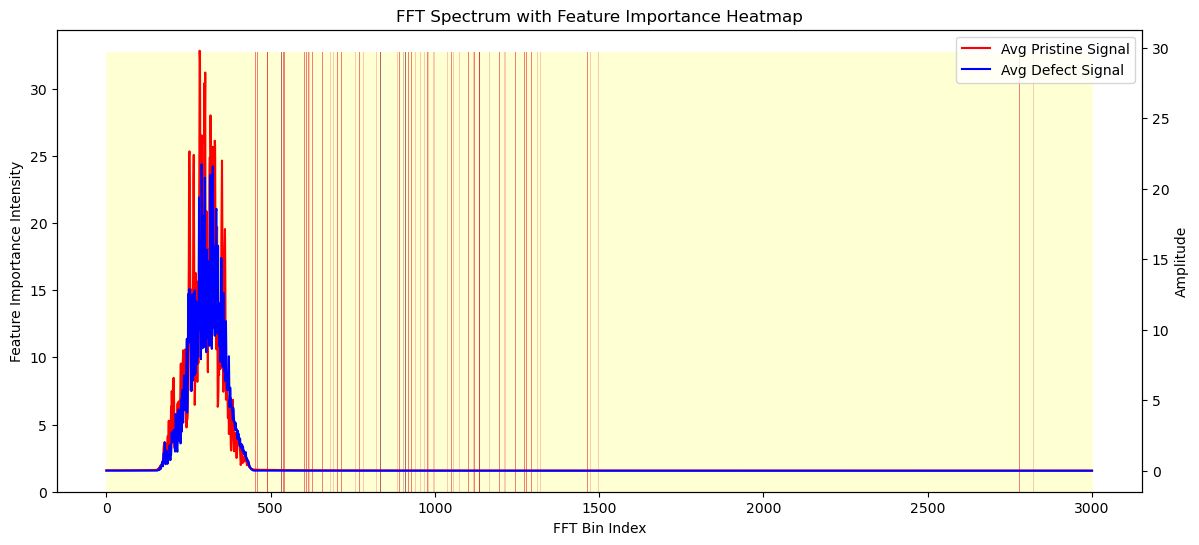

In [20]:
fft_bins = np.arange(len(importances))
feature_importance = importances  # From Random Forest

# Normalize feature importance
norm_importance = (feature_importance - np.min(feature_importance)) / (np.max(feature_importance) - np.min(feature_importance))

# Calculate average pristine and defect signals
pristine_signal = X_subset[y_subset == 0].mean(axis=0)
defect_signal = X_subset[y_subset == 1].mean(axis=0)

fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot heatmap-style background
colors = plt.cm.YlOrRd(norm_importance ** 0.5)  

ax1.bar(fft_bins, 
        [max(pristine_signal.max(), defect_signal.max()) * 1.1] * len(fft_bins),
        color=colors, width=2.0, alpha=0.6, align='edge', edgecolor='none')

# Plot FFT amplitude on secondary axis
ax2 = ax1.twinx()
ax2.plot(pristine_signal, color='red', label='Avg Pristine Signal')
ax2.plot(defect_signal, color='blue', label='Avg Defect Signal')

# Labels and title
ax1.set_xlabel('FFT Bin Index')
ax1.set_ylabel('Feature Importance Intensity')
ax2.set_ylabel('Amplitude')
plt.title('FFT Spectrum with Feature Importance Heatmap')

# Legend
ax2.legend(loc='upper right')

plt.show()

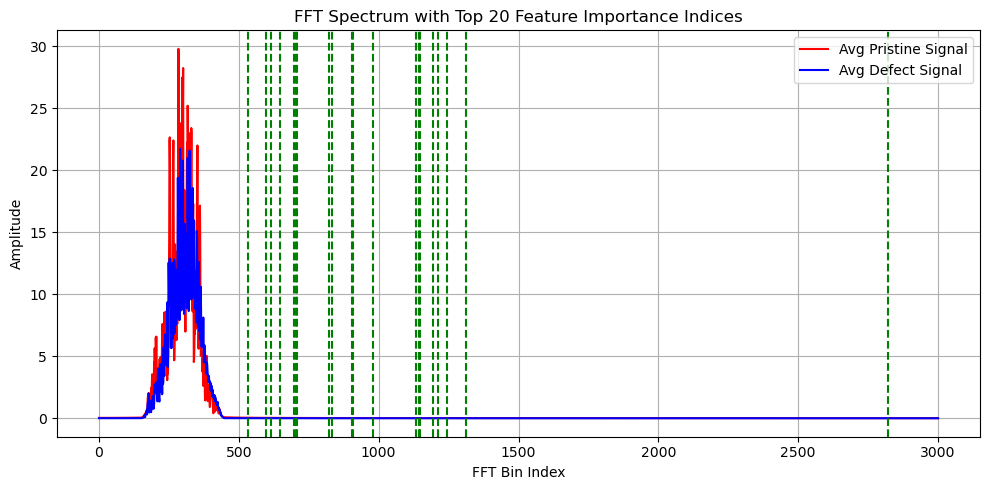

In [21]:
important_indices = indices[:20]   # From your feature importance sorting

plt.figure(figsize=(10, 5))
plt.plot(pristine_signal, color='red', label='Avg Pristine Signal')
plt.plot(defect_signal, color='blue', label='Avg Defect Signal')

# Mark important FFT indices
for idx in important_indices:
    plt.axvline(x=idx, color='green', linestyle='--')

plt.title("FFT Spectrum with Top 20 Feature Importance Indices")
plt.xlabel("FFT Bin Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

When analyzing the feature importance from the Random Forest model, it became clear that the most discriminative features, those that best separate defect signals from pristine ones are concentrated within a specific range of FFT bins. As shown in the plot, the top-ranked features are primarily located between bin indices 500 to 1200. These features were identified because, at these points in the frequency spectrum, the amplitude patterns between defect and pristine signals show the greatest distinction. In other words, this is where the model could indentify the clearest differences, making it easier to classify whether a signal is defective or not.

By focusing on this range, we leverage the part of the spectrum where separation between classes is naturally more pronounced—defect signals tend to exhibit consistently lower amplitudes compared to pristine signals within these bins. This simplifies the task of setting thresholds or building classifiers, as the overlap between classes is minimized here. 

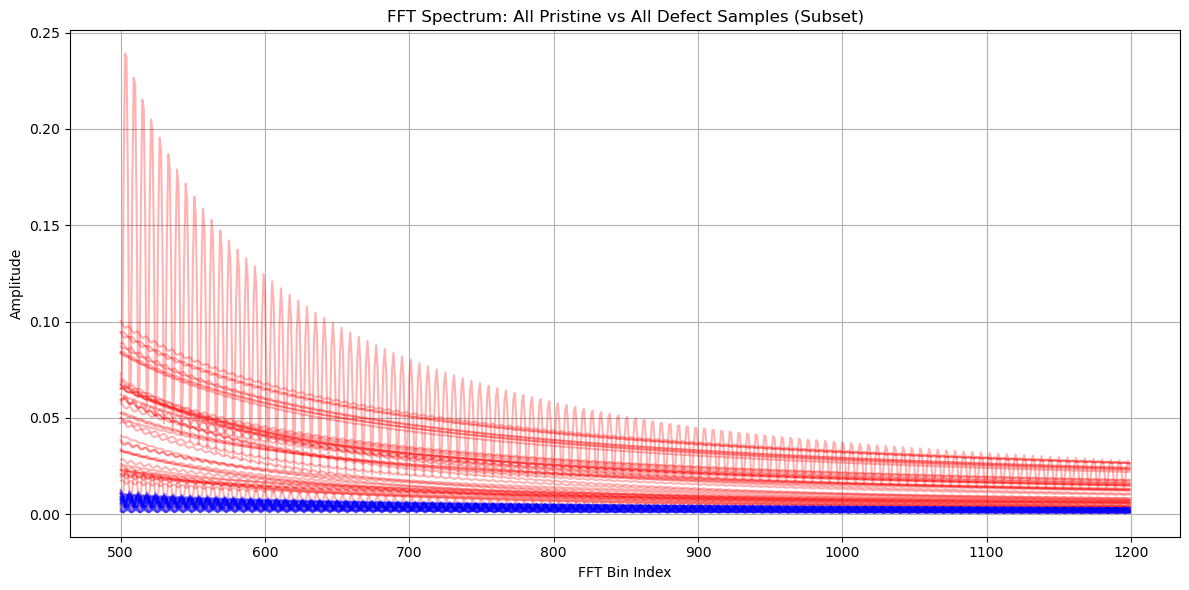

In [22]:
# Set your important frequency range
important_range_start = 500
important_range_end = 1200
fft_range = slice(important_range_start, important_range_end)

# Select ALL from subset
pristine_all = X_subset[y_subset == 0][:, fft_range]
defect_all   = X_subset[y_subset == 1][:, fft_range]

# Plotting all
plt.figure(figsize=(12, 6))

# Plot all pristine
for i in range(pristine_all.shape[0]):
    plt.plot(range(important_range_start, important_range_end),
             pristine_all[i], color='red', alpha=0.3)

# Plot all defect
for i in range(defect_all.shape[0]):
    plt.plot(range(important_range_start, important_range_end),
             defect_all[i], color='blue', alpha=0.3)

plt.title("FFT Spectrum: All Pristine vs All Defect Samples (Subset)")
plt.xlabel("FFT Bin Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

The presented plot provides a detailed analytical comparison of 15 pristine and 15 defect signals within a targeted frequency range (FFT bin indices 500 to 1200), identified as critical through feature importance analysis in the Random Forest classifier. Each curve represents the amplitude spectrum of individual samples transformed via Fast Fourier Transform (FFT), enabling observation of frequency-domain characteristics.

A clear and consistent separation between the two classes is evident. The pristine signals (red lines) exhibit substantially higher amplitude values across the entire frequency range, following a characteristic decay pattern typical of undisturbed structural responses. In contrast, the defect signals (blue lines) demonstrate significantly lower amplitudes, maintaining a compressed profile with minimal variance between samples.

This amplitude disparity suggests that the presence of defects leads to a dampening effect or energy loss within these specific frequency components, likely due to changes in structural integrity or material properties. The uniform behavior within each class, coupled with the distinct gap between pristine and defect spectra, validates the selection of this frequency band as a key discriminative feature.

From a classification perspective, this separation enhances model robustness, as the spectral signatures provide clear boundaries for decision-making. The analysis confirms that defects manifest measurable alterations in the frequency domain, making spectral features within this range highly effective for reliable defect detection and structural health assessment.

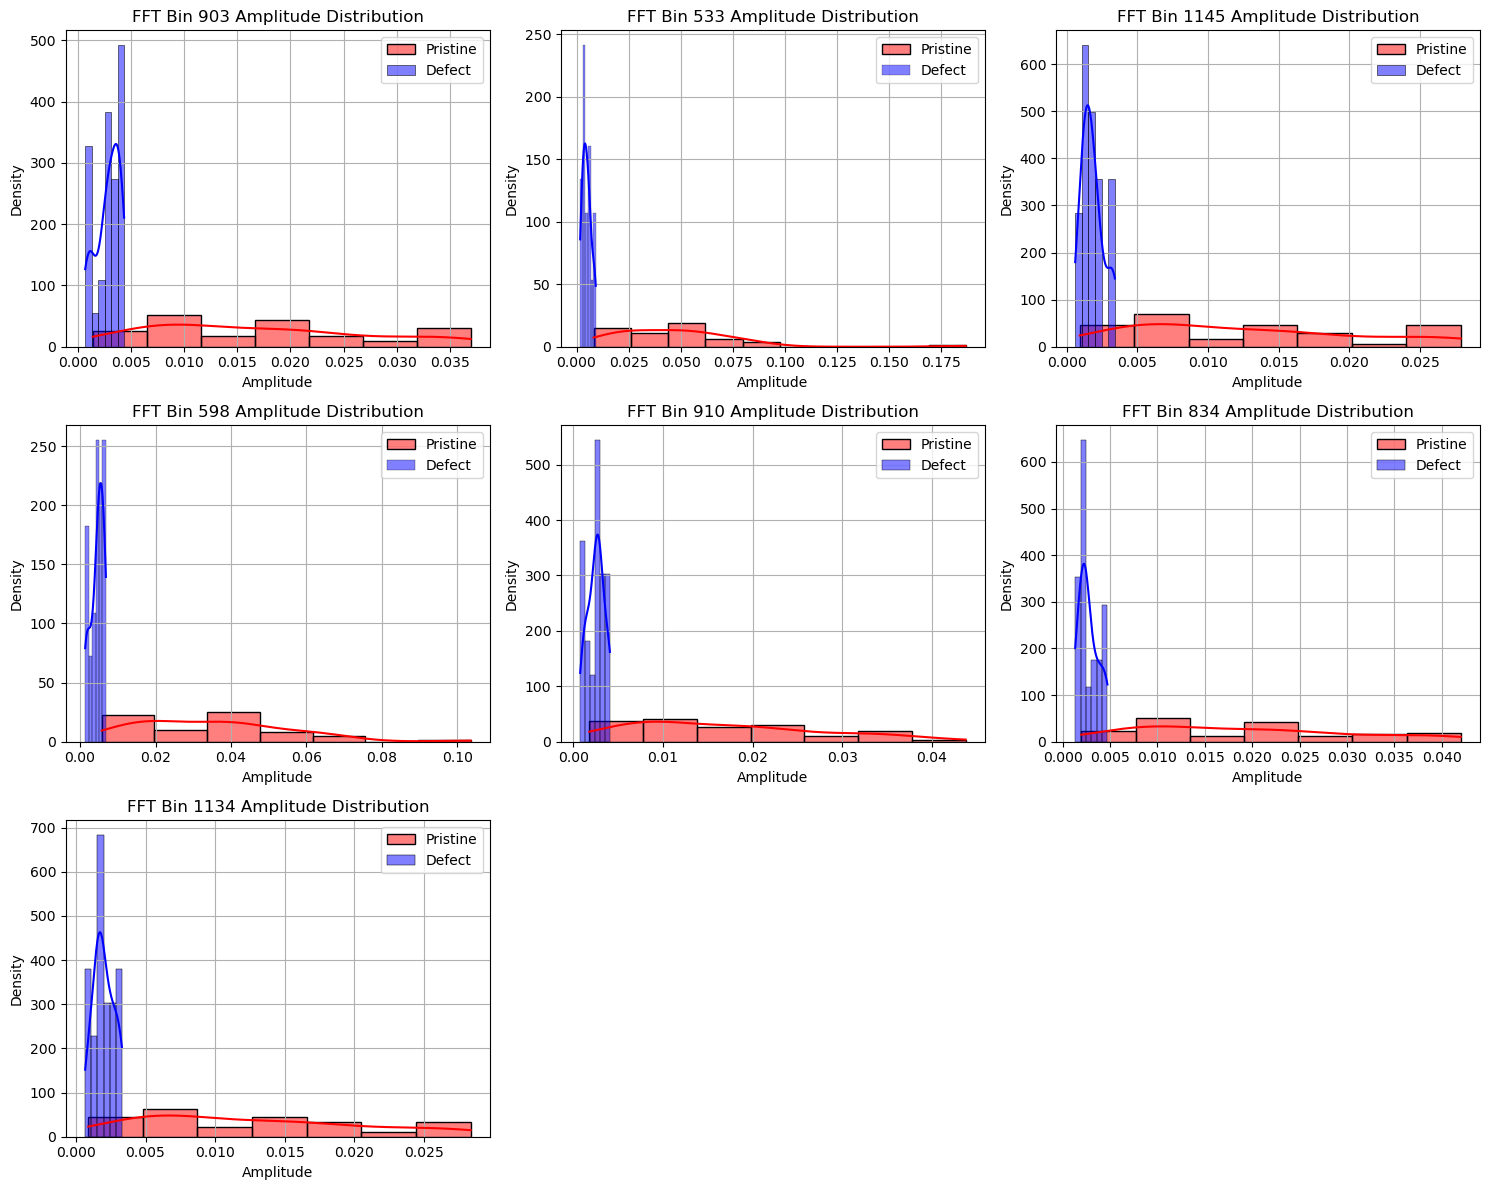

In [23]:

top_n = 7
selected_features_idx = indices[:top_n]   # From your feature importance plot
X_selected = X_subset[:, selected_features_idx]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, idx in enumerate(selected_features_idx):
    ax = axes[i]
    sns.histplot(X_subset[y_subset == 0, idx], color='red', label='Pristine', kde=True, stat='density', ax=ax)
    sns.histplot(X_subset[y_subset == 1, idx], color='blue', label='Defect', kde=True, stat='density', ax=ax)
    ax.set_title(f"FFT Bin {idx} Amplitude Distribution")
    ax.set_xlabel("Amplitude")
    ax.grid(True)
    ax.legend()

# Remove unused subplots
for j in range(len(selected_features_idx), 9):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

These histograms display the amplitude distributions at several of the most important FFT bins, as identified by feature importance analysis. Each subplot compares the amplitude behavior of pristine (red) and defect (blue) signals at a specific frequency bin.

A clear pattern emerges across all plots: the defect signals consistently exhibit much lower amplitude values, tightly clustered around a narrow range close to zero. In contrast, the pristine signals show a wider spread with noticeably higher amplitudes. This method is supported by the clear pattern seen in the visualization above, where defect signals consistently show much lower amplitudes compared to pristine signals throughout the key frequency range.

For example, in bins like 903, 910, and 1134, the defect amplitudes barely exceed a small threshold, while pristine signals have a long tail stretching towards significantly higher values. This makes it relatively straightforward to define a cutoff point that can effectively distinguish between the two classes, low amplitudes are strongly associated with defects, while higher amplitudes indicate pristine conditions.

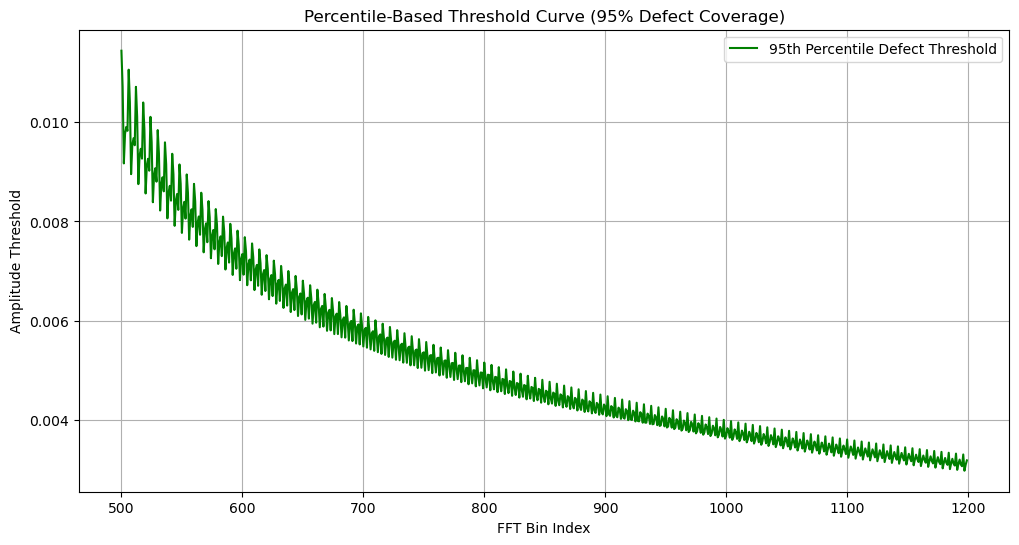

In [24]:
thresholds = []
for bin_idx in range(500, 1200):
    defect_amplitudes = X_subset[y_subset == 1, bin_idx]
    threshold = np.percentile(defect_amplitudes, 95)   # 95% of defects fall below this
    thresholds.append(threshold)

plt.figure(figsize=(12,6))
plt.plot(range(500, 1200), thresholds, label='95th Percentile Defect Threshold', color='green')
plt.xlabel("FFT Bin Index")
plt.ylabel("Amplitude Threshold")
plt.title("Percentile-Based Threshold Curve (95% Defect Coverage)")
plt.grid(True)
plt.legend()
plt.show()

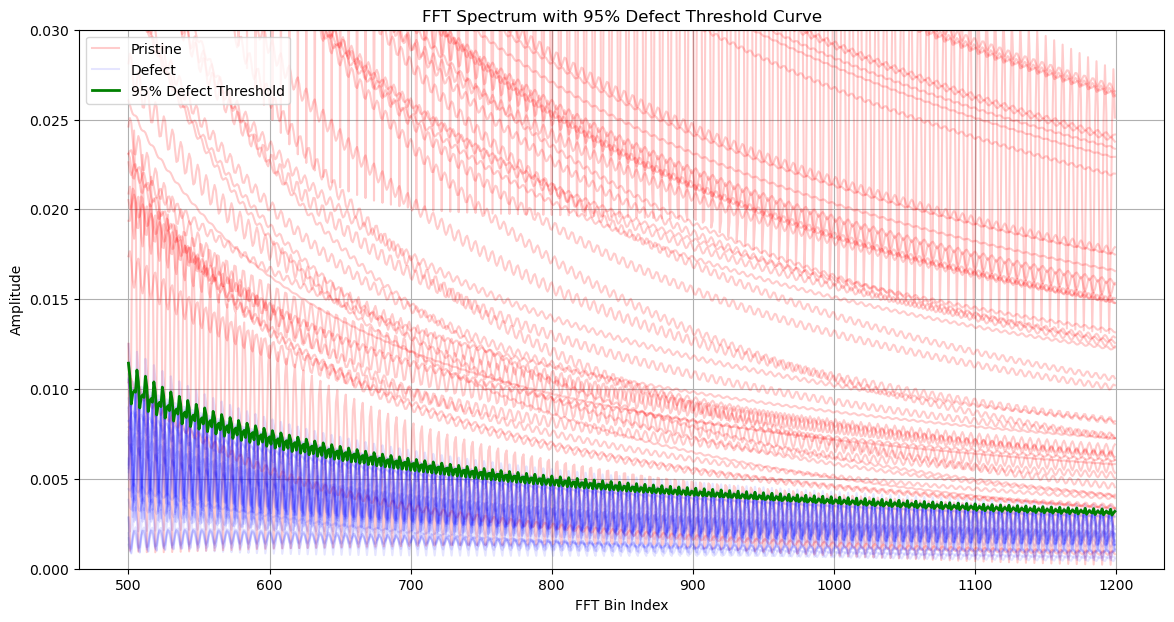

In [25]:
fft_range = slice(500, 1200)

# Extract all pristine and defect samples within that FFT range
pristine_samples = X_subset[y_subset == 0][:, fft_range]
defect_samples = X_subset[y_subset == 1][:, fft_range]

plt.figure(figsize=(14, 7))

for i, sample in enumerate(pristine_samples):
    label = 'Pristine' if i == 0 else None  # Add label once
    plt.plot(range(500, 1200), sample, color='red', alpha=0.2, label=label)

# Plot all defect samples (blue)
for i, sample in enumerate(defect_samples):
    label = 'Defect' if i == 0 else None
    plt.plot(range(500, 1200), sample, color='blue', alpha=0.1, label=label)

# Plot the threshold curve (yellow)
plt.plot(range(500, 1200), thresholds, color='green', linewidth=2, label='95% Defect Threshold')

plt.title("FFT Spectrum with 95% Defect Threshold Curve")
plt.xlabel("FFT Bin Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.ylim(0, 0.03)
plt.show()

In [26]:
thresholds_array = np.array(thresholds)

# Calculate mean and variance
threshold_mean = np.mean(thresholds_array)
threshold_variance = np.var(thresholds_array)

print(f"Threshold Line Mean: {threshold_mean:.6f}")
print(f"Threshold Line Variance: {threshold_variance:.6e}")

Threshold Line Mean: 0.005094
Threshold Line Variance: 3.203923e-06


When working with FFT-based signal analysis for defect detection, there’s always some overlap between what a normal (pristine) signal looks like and what a defect signal looks like. Because of that, it’s important to set a threshold that’s not just based on visual separation, but one that reflects a sensible trade-off between safety and efficiency.

In this case, I used the 95th percentile of defect amplitudes as the threshold across FFT bins. That means for each frequency, 95% of defect signals fall below the threshold line. The idea is simple: if a new signal’s amplitude falls below this line, it might be a defect and should be checked.

The threshold of 95% is chosen because it’s much more dangerous to miss a defect (false negative) than to flag a normal signal by mistake (false positive). If we misclassify a defect, it could lead to system failure or safety risks. But if we flag a pristine signal as a defect, the cost is just a bit of extra inspection.

Finally, I calculated the mean and variance of the threshold line to better understand how consistent this boundary is across the spectrum. The mean tells us the average cutoff amplitude, and the variance shows how much that cutoff changes depending on the frequency. Together, this gives a solid, data-driven way to separate risky signals from normal ones, without being overly strict or overly lenient.

One limitation of this approach stems from the limited number of defect samples available for training. Since defect data is scarce compared to pristine signals, we were forced to downsample the pristine class to maintain balance during model training. While this helps prevent the model from being biased toward the majority class, it also means that only a small portion of the pristine data—spread across the time range—is actually used. This selective sampling can introduce bias, as the model may not fully capture the variability present in normal operating conditions, potentially impacting its performance when exposed to unseen pristine signals.

To address this, future work should focus on collecting more defect examples to strengthen the dataset. Increasing the number of defect samples would allow us to use a larger and more representative portion of the pristine data without creating class imbalance. This would improve the model’s ability to generalize, reduce sampling bias, and enhance overall detection accuracy. A more comprehensive dataset would also open opportunities to explore advanced modeling techniques without relying heavily on artificial balancing strategies.